# SETUP

In [270]:
import numpy as np
import itertools
import requests
import datetime
import time
import json
from datetime import datetime
import pickle
import pandas as pd
import rasterio as rio
import copy
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from rasterio.transform import Affine
from rasterio.warp import calculate_default_transform, reproject, Resampling

In [252]:
print(matplotlib.__version__)
print(sns.__version__)

3.1.3
0.10.0


# Requests 

From GEO EDA sheet:

## DarkSky Sample

1) cheapest seems to be DarkSky. 1000 per day for free 2) $0.0001 per request after that 3) Request: " https://api.darksky.net/forecast/[key]/40.036944,-121.005833,2005-02-02T17:30:00" (my api key removed)

Output is like this: {"latitude":40.036944,"longitude":-121.005833,"timezone":"America/Los_Angeles","currently":{"time":1107394200,"precipIntensity":0,"precipProbability":0,"temperature":50.24,"apparentTemperature":50.41,"dewPoint":13.85,"humidity":0.23,"windSpeed":2.62,"windGust":13.17,"windBearing":24,"uvIndex":0},"hourly":{"data":
...
{"time":1107414000,"precipIntensity":0,"precipProbability":0,"temperature":41.2,"apparentTemperature":41.2,"dewPoint":12.53,"humidity":0.31,"windSpeed":1.56,"windGust":12.79,"windBearing":100,"uvIndex":0}]},"daily":{"data":[{"time":1107331200,"sunriseTime":1107357120,"sunsetTime":1107393960,"moonPhase":0.78,"precipIntensity":0,"precipIntensityMax":0,"precipProbability":0,"temperatureHigh":57.95,"temperatureHighTime":1107384600,"temperatureLow":38.42,"temperatureLowTime":1107439200,"apparentTemperatureHigh":57.45,"apparentTemperatureHighTime":1107384600,"apparentTemperatureLow":38.91,"apparentTemperatureLowTime":1107439200,"dewPoint":14.85,"humidity":0.31,"windSpeed":3.33,"windGust":14.83,"windGustTime":1107390840,"windBearing":76,"uvIndex":0,"uvIndexTime":1107331200,"temperatureMin":35.03,"temperatureMinTime":1107359100,"temperatureMax":57.95,"temperatureMaxTime":1107384600,"apparentTemperatureMin":34.3,"apparentTemperatureMinTime":1107338640,"apparentTemperatureMax":57.45,"apparentTemperatureMaxTime":1107384600}]},"flags":{"sources":["cmc","gfs","hrrr","icon","isd","madis","nam","sref"],"nearest-station":3.312,"units":"us"},"offset":-8}

## Dark Sky locality

In [5]:
# From Geo Sheet - Toy Data Bounding Box
# keep in mind each pixel is roughly 500 m x 500 m
bb_long = [-122, -119.912,-119.912,-122,-122 ]
bb_lat = [36.8, 36.8, 35.06, 35.06,36.8]

Requests, to see how how 'hyperlocal' the darksky data really is.

In [6]:
# Create Pairs
min_long = min(bb_long)
max_long = max(bb_long)
min_lat = min(bb_lat)
max_lat = max(bb_lat)

In [7]:
spaces = 10
longs = np.linspace(min_long,max_long,spaces)
lats = np.linspace(min_lat,max_lat,spaces)
print(longs, lats)
distance = (max_lat-min_lat)*110/spaces
print(f"distance between forecast pairings ~ {distance:.3} km, or {(distance/.5):.3} pixels")

[-122.    -121.768 -121.536 -121.304 -121.072 -120.84  -120.608 -120.376
 -120.144 -119.912] [35.06       35.25333333 35.44666667 35.64       35.83333333 36.02666667
 36.22       36.41333333 36.60666667 36.8       ]
distance between forecast pairings ~ 19.1 km, or 38.3 pixels


In [8]:
# Pairs
pairs = [(lat,long) for lat in lats for long in longs]
print(len(pairs))
print(pairs[25])

100
(35.446666666666665, -120.84)


In [9]:
key = '5ffac5f056d341c6296cba58fa96e9ba'

The Forecast Data API supports HTTP compression. We heartily recommend using it, as it will make responses much smaller over the wire. To enable it, simply add an `Accept-Encoding: gzip` header to your request.

### Try one request

In [57]:
# items to exclude from call
blocks = '[currently,minutely,hourly,alerts]'
# Units for call
units = 'ca'
# Time
time = '2005-02-02T12:00:00' # for noon, but hour doesn't matter as we're grabbing daily data only.
# Dates (relevant to our fires): only use one for testing
dates = ['2016-07-21']

# create time string:
date = dates[0]
time = date+'T12:00:00'
lat = str(pairs[25][0])
long = str(pairs[25][1])

query = ('https://api.darksky.net/forecast/'+key+'/'+ 
        lat+','+long+','+time+'?exclude=' 
        +blocks+'&units='+units)
headers = {'Accept-Encoding':'gzip'}
print(query)   

https://api.darksky.net/forecast/5ffac5f056d341c6296cba58fa96e9ba/35.446666666666665,-120.84,2016-07-21T12:00:00?exclude=[currently,minutely,hourly,alerts]&units=ca


In [58]:
r=requests.get(query,headers=headers)

In [59]:
r.status_code

200

In [61]:
weather = r.json()
weather['daily']['data']

[{'time': 1469084400,
  'summary': 'Foggy in the morning.',
  'icon': 'clear-day',
  'sunriseTime': 1469106300,
  'sunsetTime': 1469157360,
  'moonPhase': 0.58,
  'precipIntensity': 0,
  'precipIntensityMax': 0,
  'precipProbability': 0,
  'temperatureHigh': 32.15,
  'temperatureHighTime': 1469138220,
  'temperatureLow': 13.71,
  'temperatureLowTime': 1469194800,
  'apparentTemperatureHigh': 31.87,
  'apparentTemperatureHighTime': 1469138220,
  'apparentTemperatureLow': 13.98,
  'apparentTemperatureLowTime': 1469194800,
  'dewPoint': 9.95,
  'humidity': 0.56,
  'pressure': 1016.3,
  'windSpeed': 6.1,
  'windGust': 20.82,
  'windGustTime': 1469145600,
  'windBearing': 268,
  'cloudCover': 0.08,
  'uvIndex': 11,
  'uvIndexTime': 1469131740,
  'visibility': 15.083,
  'temperatureMin': 11.36,
  'temperatureMinTime': 1469104980,
  'temperatureMax': 32.15,
  'temperatureMaxTime': 1469138220,
  'apparentTemperatureMin': 11.63,
  'apparentTemperatureMinTime': 1469104980,
  'apparentTemperature

In [62]:
# Parsed important elements:
dailydata = weather['daily']['data'][0]
rain = dailydata['precipIntensityMax']
hitemp = dailydata['temperatureHigh']
lotemp = dailydata['temperatureLow']
humidity = dailydata['humidity']
windspd = dailydata['windSpeed']
winddir = dailydata['windBearing']
clouds = dailydata['cloudCover']

In [63]:
point = [date,lat,long,rain,hitemp,lotemp,humidity,windspd,winddir,clouds]

In [64]:
point

['2016-07-21',
 '35.446666666666665',
 '-120.84',
 0,
 32.15,
 13.71,
 0.56,
 6.1,
 268,
 0.08]

In [65]:
print(type(point))

<class 'list'>


In [66]:
pairs[0][0]

35.06

## Multiple Requests to determine degree of hyperlocality required

### Https requests functions

In [2]:
def getweather(coordinates,date,key):
    """ Function to take the set of coordinates and get the daily
    weather for a given date. rain, hi and low temps, humidity
    wind speed and direction and cloud cover only.
    
    Input: Date, API Key and list of coordinate pairs (lat,long)
    Output: list of jsons
    """
    # items to exclude from call
    blocks = '[currently,minutely,hourly,alerts]'

    # Units for call
    units = 'ca'
    
    # Compression for call
    headers = {'Accept-Encoding':'gzip'}
    
    time = date+'T12:00:00'
    
    data_out = []
    for pair in coordinates:
        lat = str(pair[0])
        long = str(pair[1])
        # set the query string for darksky
        query = ('https://api.darksky.net/forecast/'+key+'/'+ 
            lat+','+long+','+time+'?exclude=' 
            +blocks+'&units='+units)
        # Make the call to Dark Sky to get all the data for that date and location
        r=requests.get(query,headers=headers)
        
        # get the weather data from the request return
        weather=r.json()
        
        # write the jsons as items in the output data list
        data_out.append(weather)
    
    return data_out

In [10]:
%%time
# Dates (relevant to our fires): only use one for testing
dates = ['2016-07-21']
# create time string:
date = dates[0]

data_for_date = getweather(pairs,date,key)

CPU times: user 3.36 s, sys: 129 ms, total: 3.49 s
Wall time: 38.7 s


In [253]:
%%time
# Pickle results out so that i don't have to make another api call later
with open('../data/GlobalFire2016/weathertest.pickle','wb') as f:
    pickle.dump(data_for_date,f,pickle.HIGHEST_PROTOCOL)

Wall time: 58 ms


In [254]:
def check_point(info):
    """ to check if there is a value for that weather element and provide 
    either None or the value back
    """
    if info:
        return info
    else:
        return None

In [255]:
def date_df(data_out):
    """ Function to take the list of jsons from a date
    of daily weather requests and create a pandas dataframe
    
    Input: list of jsons containing the weather data
    Output: pandas dataframe
    """
    data_convert=[]
    # Titles for the data
    coltitles = ['date','latitude','longitude','rain','High T','Low T','Humidity','Wind Speed','Wind Direction','Cloud Cover']
    data_convert.append(coltitles)
    # Loope through all the geopoints to get the data
    for point in data_out:
        lat = point['latitude']
        long = point['longitude']
        daily = point.get('daily')
        if daily:
            data = daily['data'][0]
            time = datetime.fromtimestamp(data['time']).strftime('%Y-%m-%d')
            rain = data.get('precipIntensityMax')
            hitemp = data.get('temperatureHigh')
            lotemp = data.get('temperatureLow')
            humidity = data.get('humidity')
            windspd = data.get('windSpeed')
            winddir = data.get('windBearing')
            clouds = data.get('cloudCover')
            point = [date,lat,long,check_point(rain), \
                     check_point(hitemp),check_point(lotemp), \
                     check_point(humidity),check_point(windspd), \
                     check_point(winddir), check_point(clouds)] 
            data_convert.append(point)
        else:
            point = None
            
    df = pd.DataFrame(data_convert[1:], columns = data_convert[0])
    
    return df


In [256]:
df2 = date_df(data_for_date)
df2.head()

,date,latitude,longitude,rain,High T,Low T,Humidity,Wind Speed,Wind Direction,Cloud Cover
0,2016-07-21,35.06,-121.536,None,15.09,13.82,NaN,33.49,327.0,NaN
1,2016-07-21,35.06,-121.304,None,15.09,13.82,0.84,33.49,327.0,NaN
2,2016-07-21,35.06,-121.072,None,20.81,13.73,0.77,7.59,275.0,0.20
3,2016-07-21,35.06,-120.840,None,22.47,13.97,0.71,6.77,274.0,0.37
4,2016-07-21,35.06,-120.608,None,22.16,13.00,0.73,6.60,247.0,0.38


In [264]:
df2.tail()

,date,latitude,longitude,rain,High T,Low T,Humidity,Wind Speed,Wind Direction,Cloud Cover
90,2016-07-21,36.8,-120.840,None,33.55,14.14,0.37,10.03,336.0,NaN
91,2016-07-21,36.8,-120.608,None,35.21,15.74,0.34,10.91,326.0,NaN
92,2016-07-21,36.8,-120.376,None,35.17,15.74,0.33,10.00,321.0,NaN
93,2016-07-21,36.8,-120.144,None,36.14,16.75,0.34,7.93,308.0,0.01
94,2016-07-21,36.8,-119.912,None,36.49,17.21,0.34,7.37,306.0,0.01


### Look at uniqueness

In [16]:
stats = df2.describe()

In [14]:
cols = stats.columns

In [15]:
uniques = []
for col in cols:
    uniq = len(df2[col].value_counts())
    uniques.append(uniq)
uniques = pd.DataFrame([uniques],columns=cols)

In [16]:
uniques.rename(index={0:'Uniques'},inplace = True)

In [17]:
newstats = stats.append(uniques)
newstats

,latitude,longitude,High T,Low T,Humidity,Wind Speed,Wind Direction,Cloud Cover
count,95.000000,95.000000,95.000000,95.000000,90.000000,95.000000,94.000000,45.000000
mean,35.969684,-120.910821,29.696211,13.639895,0.491333,10.315368,279.042553,0.179111
std,0.543820,0.655386,6.749324,3.248108,0.166458,8.650780,88.161498,0.117818
min,35.060000,-122.000000,15.090000,6.050000,0.280000,4.510000,4.000000,0.010000
25%,35.446667,-121.536000,25.425000,11.275000,0.340000,6.605000,277.250000,0.080000
50%,36.026667,-120.840000,32.040000,13.330000,0.450000,7.440000,306.000000,0.200000
75%,36.413333,-120.376000,35.235000,15.740000,0.657500,9.260000,322.000000,0.280000
max,36.800000,-119.912000,38.660000,20.560000,0.840000,42.090000,358.000000,0.390000
Uniques,10.000000,10.000000,88.000000,88.000000,42.000000,89.000000,62.000000,27.000000


## Turn data into 2D numpy arrays

The above says that the data is fairly hyperlocal. Try doing heat maps?
To do heatmaps, have to turn this into a numpy array which i have to do anyway

### Create the numpy arrays

In [257]:
# Create Numpy Array for High T first: - Not sure I need this....
X,Y = np.meshgrid(longs,lats)

In [258]:
# Create numpy array for High Temperature
# create a list of all the values by increasing longitude for each latitude, so we can vstack into array

# Subset the dataframe
sub = df2[['latitude','longitude','High T']]

# All values of longitude, to ensure square matrix
long_df = pd.DataFrame(longs,columns=['longitude'])

hiT = []

# reverse the latitudes so we start with largest first
lats2 = list(copy.deepcopy(lats))
lats2.reverse()

# loop through each latitude
for lat in lats2:
    # get the row values for each latitude, sort by longitude
    row = sub[sub['latitude']==lat].sort_values(by=['longitude'])
    
    # add in missing longitude if necessary
    row2 = long_df.merge(row,how='left')
    
    # Fill any missing values of latitude if needed
    row2['latitude'].fillna(lat,inplace=True)
    
    # pull out just the High T
    row3 = row2['High T']
    
    # reshape array
    row3 = np.array(row3)[np.newaxis] 
    
    hiT.append(row3)

In [259]:
x = np.vstack(hiT)

In [260]:
x.shape

(10, 10)

In [261]:
HighTempArray = x

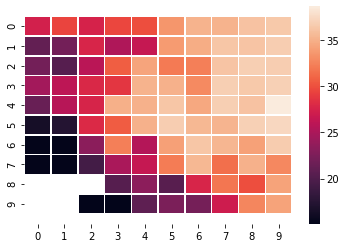

In [262]:
ax = sns.heatmap(HighTempArray, linewidth=0.5)

# Fix the cutoff heatmap issue
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.show()

In [295]:
HighTempArray.shape[0]

10

### Create a GEOTIFF on the Lat/Long data

must create geotiff first, then change crs, then upsample

In [263]:
# from https://rasterio.readthedocs.io/en/latest/quickstart.html#creating-data

# Resolution
res = (longs[-1] - longs[0]) / 10
transform = Affine.translation(longs[0] - res / 2, lats[0] - res / 2) * Affine.scale(res, res)
transform

Affine(0.20879999999999937, 0.0, -122.1044,
       0.0, 0.20879999999999937, 34.955600000000004)

In [293]:
new_meta = {'driver':'GTiff','height':HighTempArray.shape[0], \
           'width':HighTempArray.shape[1],'count':1, \
           'dtype':HighTempArray.dtype, 'crs':'+proj=latlong', \
           'transform':transform, 'nodata':-9999, \
           'compress':'lzw','interleave':'band'}

In [296]:
with rio.open('../data/GlobalFire2016/hitemp.tif','w', **new_meta) as new:
    new.write(HighTempArray,1)

In [323]:
with rio.open('../data/GlobalFire2016/hitemp.tif','r') as ht:
    htmeta = ht.meta
    ht_data = ht.read()

In [304]:
htmeta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': -9999.0,
 'width': 10,
 'height': 10,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.20879999999999937, 0.0, -122.1044,
        0.0, 0.20879999999999937, 34.955600000000004)}

### Reproject and upsample weather data to fire crs

In [317]:
with rio.open('../data/GlobalFire2016/Global_fire_atlas_firelinecrop.tif','r') as dst:
    firemeta = dst.meta
    fireline = dst.read()
    fireres = dst.res

In [316]:
firemeta['transform']

Affine(509.9863732168427, 0.0, -13581080.848881941,
       0.0, -509.9928633270912, 4411268.819459678)

In [318]:
fireres

(509.9863732168427, 509.9928633270912)

In [308]:
src_crs = htmeta['crs']
dst_crs = firemeta['crs']

In [311]:
print('source crs = ',src_crs,'\ndestination crs =',dst_crs)

source crs =  EPSG:4326 
destination crs = EPSG:3857


#### First Method

In [322]:
# From https://www.programcreek.com/python/example/107895/rasterio.warp Example 3
# read the source raster
with rio.open('../data/GlobalFire2016/hitemp.tif') as src:
    Array = src.read()
    OldResolution = src.res
    print(OldResolution)

    #setup output resolution
    NewResolution = fireres
    print(NewResolution)

    # setup the transform to change the resolution
    XResRatio = OldResolution[0]/NewResolution[0]
    YResRatio = OldResolution[1]/NewResolution[1]
    print(XResRatio,YResRatio)
    print(Array.shape[0],Array.shape[1],Array.shape[2])
    NewArray = np.empty(shape=(Array.shape[0], int(round(Array.shape[1] * XResRatio)), int(round(Array.shape[2] * YResRatio))))
    print(NewArray.shape)
#     Aff = src.affine
#     NewAff = affine.Affine(Aff.a/XResRatio, Aff.b, Aff.c, Aff.d, Aff.e/YResRatio, Aff.f)

#     # reproject the raster
#     reproject(Array, NewArray, src_transform=Aff, dst_transform=NewAff, src_crs = src.crs, dst_crs = src.crs, resample=Resampling.bilinear)

#     # write results to file
#     with rasterio.open(OutputRasterFile, 'w', driver=src.driver, \
#                         height=NewArray.shape[1],width=NewArray.shape[2], \
#                         nodata=src.nodata,dtype=str(NewArray.dtype), \
#                         count=src.count,crs=src.crs,transform=NewAff) as dst:
#         dst.write(NewArray) 

(0.20879999999999937, -0.20879999999999937)
(509.9863732168427, 509.9928633270912)
0.0004094227041458989 -0.0004094174938798752
1 10 10
(1, 0, 0)


#### Second Method

In [333]:
with rio.open('../data/GlobalFire2016/hitemp.tif','r') as ht:
    # Calculate the transform using the rasterio warp function
    transform2,width,height = calculate_default_transform(ht.crs,dst_crs,ht.width,ht.height,*ht.bounds)

    # Set the new meta data for the projected weather raster file
    kwargs = ht.meta.copy()
    kwargs.update({'crs':dst_crs,
                  'transform':transform2,
                  'width':width,
                  'height':height,
                  'compress':'lzw'
                  })

    # Filename for writing out to
    filestring = '../data/GlobalFire2016/Global_fire_atlas_bbweather_2016_reproj.tif'

    # write the new raster file by using the rasterio reproject function
    with rio.open(filestring,'w',**kwargs) as dst:
        for i in range(1, ht.count + 1):
            reproject(
                source = rio.band(ht,i),
                destination=rio.band(dst,i),
                src_transform = ht.transform,
                src_crs = ht.crs,
                dst_transform = transform2,
                dst_crs = dst_crs,
                resampling=Resampling.lanczos)  

In [330]:
transform2

Affine(26133.17024701767, 0.0, -13592599.631618194,
       0.0, -26133.17024701767, 4445185.808670735)

In [331]:
width,height

(9, 11)

#### Third Method

In [ ]:
with rio.open('../data/GlobalFire2016/hitemp.tif','r') as src:
    with rio.open('../data/GlobalFire2016/fireid.tif','r') as dst:
        reproj = rio.warp.reproject(src,)

#### Check that raster data was projected and written correctly

In [334]:
with rio.open('../data/GlobalFire2016/Global_fire_atlas_bbweather_2016_reproj.tif','r') as weath_reproj:
    wmeta = weath_reproj.meta
    weath_data = weath_reproj.read(1)
    weath_reproj_crs = weath_reproj.crs

In [335]:
wmeta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': -9999.0,
 'width': 9,
 'height': 11,
 'count': 1,
 'crs': CRS.from_epsg(3857),
 'transform': Affine(26133.17024701767, 0.0, -13592599.631618194,
        0.0, -26133.17024701767, 4445185.808670735)}

In [336]:
weath_data

array([[        nan,         nan,         nan,         nan,         nan,
                nan, 22.12083574, 26.71513555, 34.43556786],
       [        nan,         nan,         nan,         nan,         nan,
                nan, 26.27560754, 31.07062556, 34.13872538],
       [        nan,         nan,         nan,         nan,         nan,
                nan, 33.78516946, 31.98732962, 32.88312442],
       [        nan,         nan,         nan,         nan,         nan,
                nan, 36.86997494, 34.27394019, 35.32338486],
       [        nan,         nan,         nan,         nan,         nan,
                nan, 35.9898817 , 35.4389317 , 37.29216429],
       [18.37889175, 21.28214629, 28.18406536, 33.05718626, 36.26657755,
        36.83998397, 35.17057917, 35.72584363, 38.11715838],
       [23.52292038, 26.84388752, 28.16032644, 32.81499193, 35.11064274,
        35.81992146, 34.34487748, 36.72539329, 38.02653526],
       [24.18455133, 24.46899496, 26.99115956, 29.22795839, 35

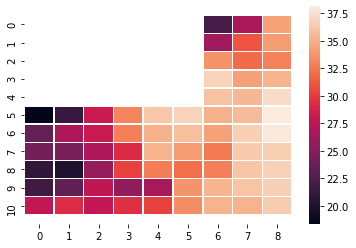

In [338]:
# Plot to test
ax = sns.heatmap(weath_data, linewidth=0.5)

# Fix the cutoff heatmap issue
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.show()